In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout,Activation, Lambda,LeakyReLU,ReLU
from tensorflow.keras.layers import Conv2D,MaxPooling2D,BatchNormalization,LayerNormalization,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import pandas as pd
import numpy as np
import os

from image_utils import get_pairs,get_dataset_info,estimate_dataset


# Object classification

## Define images main information

In [2]:
main_folder_name='sof dataset'
get_dataset_info(main_folder_name)

-------------------------------------------------------
Dataset info

image shape =  (128, 128, 3)
image weight =  48.0  KiB uint8
number of classes =  4
number of pictures =  164

positive pairs count = 8506
positive pairs images weight = 0.779  GiB (uint8) 

negative pairs count = 18390
negative pairs images weight = 1.684  GiB (uint8) 

total memory size = 2.463  GiB (uint8)


## Define dataset parametrs 

In [3]:
image_shape=(128,128,3)
max_positive_pairs_count=13000
max_negative_pairs_count=12000
estimate_dataset(main_folder_name,
                 max_positive_pairs_count,
                 max_negative_pairs_count)

-------------------------------------------------------
Estimated info

desired positive pairs count = 13000
positive pairs images weight = 1.19  GiB (uint8) or  4.761 GiB (float32)

desired negative pairs count = 12000
negative pairs images weight = 1.099  GiB (uint8) or  4.395 GiB (float32)

total memory size = 2.289  GiB


## Preprocces the images

In [11]:
pairs,labels=get_pairs(main_folder_name,
                       max_positive_pairs_count,
                       max_negative_pairs_count)

Calculation began

Calculation is done

passed seconds:  49.299  seconds


In [12]:
train_pairs,test_pairs,train_labels,test_labels=train_test_split(pairs,labels,test_size=0.05)

## Siamese pecularity

As siamese network measure distance between we define Euclidean distance Lambda layer and special contrastive loss ( https://arxiv.org/abs/2011.02803 )

In [13]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
    
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean( (1 - y_true) * square_pred+y_true*margin_square)
    
    return contrastive_loss

In [14]:
def get_model():
    #
    #   it is also good idea to use VGG model, but it requires powerfull GPU
    #   model = Sequential(VGG16(weights='imagenet', include_top=False, input_shape=image_shape).layers)
    #
    model=Sequential()
    
    model.add(Conv2D(32,(3,3),input_shape=image_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3)))
    model.add(MaxPooling2D((2,2)))
        
    model.add(Conv2D(64,(3,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3)))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(128,(3,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3)))
    model.add(MaxPooling2D((3,3)))
    
    model.add(Conv2D(256,(3,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3)))
    model.add(MaxPooling2D((3,3)))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))

    return model

In [15]:
base_network = get_model()
base_network.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 64)        256       
_________________________________________

## Define siamese model

To provide weights sycronization we define left and right inputs with the same model

In [16]:
input_a = Input(shape=image_shape)
vect_output_a = base_network(input_a)

input_b = Input(shape=image_shape)
vect_output_b = base_network(input_b)

x = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])
output= Dense(1,activation='sigmoid')(x)

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256)          1437088     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[1][0]             

## Model training

*Important*, 43 epochs take 4 hours to train on gxt 980 ti. Make sure, that you have enough computation power

In [20]:
optim = RMSprop(  learning_rate=0.0001)
#optim = Adam(  learning_rate=0.015)
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=optim)
history = model.fit([train_pairs[:,0],train_pairs[:,1]], 
                    train_labels, 
                    epochs=17, 
                    batch_size=18,
                    validation_split=0.2)

Train on 19000 samples, validate on 4750 samples
Epoch 1/17
19000/19000 [==============================] - 260s 14ms/sample - loss: 0.2341 - val_loss: 0.2333
Epoch 2/17
19000/19000 [==============================] - 280s 15ms/sample - loss: 0.2253 - val_loss: 0.2277
Epoch 3/17
19000/19000 [==============================] - 284s 15ms/sample - loss: 0.2164 - val_loss: 0.2176
Epoch 4/17
19000/19000 [==============================] - 299s 16ms/sample - loss: 0.2038 - val_loss: 0.2058
Epoch 5/17
19000/19000 [==============================] - 299s 16ms/sample - loss: 0.1904 - val_loss: 0.1976
Epoch 6/17
19000/19000 [==============================] - 260s 14ms/sample - loss: 0.1758 - val_loss: 0.1805
Epoch 7/17
19000/19000 [==============================] - 260s 14ms/sample - loss: 0.1595 - val_loss: 0.1700
Epoch 8/17
19000/19000 [==============================] - 259s 14ms/sample - loss: 0.1430 - val_loss: 0.1516
Epoch 9/17
19000/19000 [==============================] - 260s 14ms/sample - lo

## Save weights and history

In [21]:
saved_path='saved data'

#weights_name='georges_weight.h5'
#history_name='georges_history.json'

weights_name='georges_weight.h5'
history_name='georges_history.json'

hist_json_file = saved_path+'/'+history_name
weights_file=saved_path+'/' +weights_name

model.save_weights(weights_file)
hist_df = pd.DataFrame(history.history)  

with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

## Load weights and history

In [32]:
saved_path='saved data'

#weights_name='human_weight.h5'
#history_name='human_history.json'

weights_name='georges_weight.h5'
history_name='georges_history.json'

hist_json_file = saved_path+'/'+history_name
weights_file=saved_path+'/' +weights_name

model.load_weights(weights_file)
loaded_history=pd.read_json(hist_json_file)

## Loss plot

In [43]:
def plot_loss(loaded_history,title):
    loss=loaded_history['loss']
    val_loss=loaded_history['val_loss']
    x=range(len(loss))
    X=15
    Y=8
    plt.figure(figsize=(X,Y))
    plt.plot(x,loss,'b',x,val_loss,'g')
    plt.title(title, fontsize=20, fontname='Times New Roman')
    plt.legend(['loss','val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

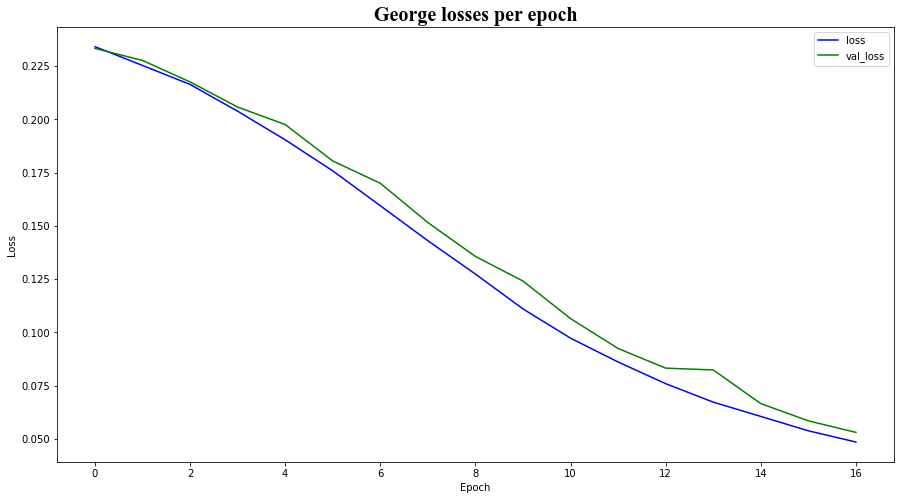

In [45]:
title='George losses per epoch'
plot_loss(loaded_history,title)

## Model testing

To compute accuracy of the model define rule: if predicted value is bigger, then 0.5, the result is 1, else 0

In [36]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() > 0.5
    return round(np.mean(pred == y_true),4)

In [37]:
loss = round(model.evaluate(x=[test_pairs[:,0],test_pairs[:,1]], y=test_labels),4)

y_pred_train = model.predict([test_pairs[:,0], test_pairs[:,1]])
train_accuracy = compute_accuracy(test_labels, y_pred_train)

y_pred_test = model.predict([test_pairs[:,0], test_pairs[:,1]])
test_accuracy = compute_accuracy(test_labels, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

1250/1250 [==============================] - 5s 4ms/sample - loss: 0.0556
Loss = 0.0556, Train Accuracy = 0.5001 Test Accuracy = 0.5001
